In [0]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip -O temp.zip; unzip temp.zip; rm temp.zip

--2019-01-31 07:52:20--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-01-31 07:52:20--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘temp.zip’

temp.zip            100%[===================>]   2.03G  60.6MB/s    in 35s     

2019-01-31 07:52:55 (59.9 MB/s) - ‘temp.zip’ saved [2176768927/2176768927]

Archive:  temp.zip
  inflating: glove.840B.300d.txt     


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

np.random.seed(100)

## Step 1 : Loading Word Embeddings

In [0]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [0]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [0]:
glove = load_embedding('glove.840B.300d.txt')

I'm using GloVe, because that's the embedding I got the best results with inbefore, but paragram is quite good as well.

## Step 2 : Loading Data

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1DnWHFdfNYEpvegCNNPzCWpNXUuK9t7FC',     # Id of file to be downloaded
                                    dest_path='data/offenseval-training-v1.tsv')     # Destination path

In [0]:
import pandas as pd
df = pd.read_table("data/offenseval-training-v1.tsv",sep='\t',index_col=False, error_bad_lines=False) 
df = df.loc[df['subtask_a'] == 'OFF']
df = df.loc[df['subtask_b'] == 'TIN']
df = df.drop(['subtask_a','subtask_b'],axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['subtask_c'])
df=X_train

In [0]:
len(list(df['tweet'].str.split(' ', expand=True).stack().unique()))

14834

In [0]:
df.head(10)

,id,tweet,subtask_c
123,77294,@USER @USER She is an ugly black hearted troll...,IND
2896,35558,.@USER Liberals are steamrolling #TPP through ...,OTH
10324,36031,@USER Don't bury the lead fam! It has nothing ...,GRP
13150,18931,@USER @USER It’s unwatchable. I am careful sur...,OTH
6934,16577,@USER Myyy nigga ✊🏾,GRP
1004,87501,@USER Coming from a guy who worries more about...,IND
7845,33684,@USER She should be fired and arrested. Clearl...,IND
5995,21106,@USER And people still buy their shit. Why?,GRP
1649,79939,@USER @USER @USER @USER @USER I’m gunna fuckin...,IND
10313,49109,@USER Oh well. Its tje liberals and socialists...,GRP


In [0]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords

from scipy.stats import itemfreq
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.metrics import confusion_matrix

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()  
  
pd.options.mode.chained_assignment = None

def clean_text(content):
  content=content.str.replace('@USER','')                                     # Remove triggerword tags
  content=content.str.lower()                                                         # Convert to Lowercase
  content=content.str.replace('username','')                                          # Remove username tags
  content=content.str.replace('http\S+|www.\S+', '')                                  # Remove Links
  content=content.str.replace('\s+', ' ')                                             # Remove multiple spaces
  content=content.str.replace('[^A-Za-z\s]+', '')                                     # Remove irrelevant characters grper than alphabets and space
  #content=content.apply(lemmatize_sentences)
  return content

In [0]:
df['tweet'] = clean_text(df['tweet'])
X_test['tweet'] = clean_text(X_test['tweet'])

In [0]:
df.head(10)

,id,tweet,subtask_c
123,77294,she is an ugly black hearted troll url,IND
2896,35558,liberals are steamrolling tpp through parliam...,OTH
10324,36031,dont bury the lead fam it has nothing to do w...,GRP
13150,18931,its unwatchable i am careful surfing around t...,OTH
6934,16577,myyy nigga,GRP
1004,87501,coming from a guy who worries more about stra...,IND
7845,33684,she should be fired and arrested clearly she ...,IND
5995,21106,and people still buy their shit why,GRP
1649,79939,im gunna fucking die oh my god,IND
10313,49109,oh well its tje liberals and socialists who h...,GRP


### Class imbalance

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


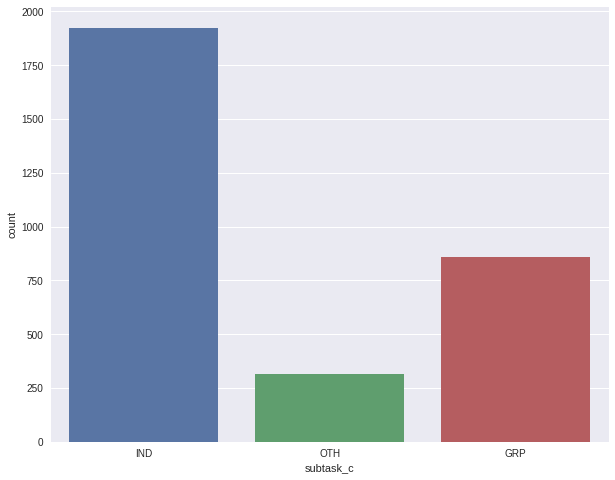

In [0]:
plt.figure(figsize = (10, 8))
sns.countplot(df['subtask_c'])
plt.show()

In [0]:
print("Class repartition : ", (Counter(df['subtask_c'])))

Class repartition :  Counter({'IND': 1925, 'GRP': 859, 'OTH': 316})


There is way more 0s than 1s in our dataset. As mentionned, we could use data augmentation to balance classes. Therefore the prediction task will be easier.

## Step 3: Tokenizing

I am using Keras' Tokenizer to apply some text processing and to limit the size of the vocabulary

In [0]:
len_voc = 15000

#### Tokenizing

In [0]:
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

In [0]:
tokenizer = make_tokenizer(df['tweet'], len_voc)

Using TensorFlow backend.


In [0]:
X = tokenizer.texts_to_sequences(df['tweet'])

In [0]:
max([len(x) for x in X])

61

In [0]:
X[0]

[14, 2, 63, 546, 160, 2486, 1144, 22]

I also apply padding, mostly to store X as an array.

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, 70)

In [0]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   14,    2,   63,  546,
        160, 2486, 1144,   22], dtype=int32)

In [0]:
y = df['subtask_c'].values

For visualization, I'm gonna need to see which index corresponds to which word

In [0]:
index_word = {0: ''}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

In [0]:
len(index_word)

8792

#### Embedding Matrix

In [0]:
embed_mat = make_embedding_matrix(glove, tokenizer, len_voc)

## Step 3 : Making a Synonym Dictionary

Word vectors are made in a way that similar words have similar representation. Therefore we can use the $k$-nearest neighbours to get $k$ synonyms.

As the process takes a bit of time, I chose to compute 5 synonyms for the 20000 most frequent words.

In [0]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 9000

In [0]:
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat) 

#### We create Synonyms for the most frequent words

In [0]:
neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]

In [0]:
synonyms = {x[0]: x[1:] for x in neighbours_mat}

### Checking our synonyms

In [0]:
for x in np.random.randint(1, word_number, 10):
    print(f"{index_word[x]} : {[index_word[synonyms[x][i]] for i in range(synonyms_number-1)]}")

harm : ['harms', 'harmed', 'consequences', 'danger']
gen : ['fyi', 'esp', 'prob', 'wont']
understanding : ['knowledge', 'understand', 'aspects', 'sense']
budget : ['spending', 'plan', 'considering', 'plans']
describing : ['describe', 'describes', 'explaining', 'referring']
mondaymood : ['up', 'back', 'earlier', 'again']
enabler : ['secondly', 'brainer', 'imperative', 'imho']
changed : ['change', 'once', 'changing', 'same']
legislative : ['congressional', 'legislation', 'judicial', 'constitutional']
lapdpgs : ['we', 'count', 'seen', 'counted']


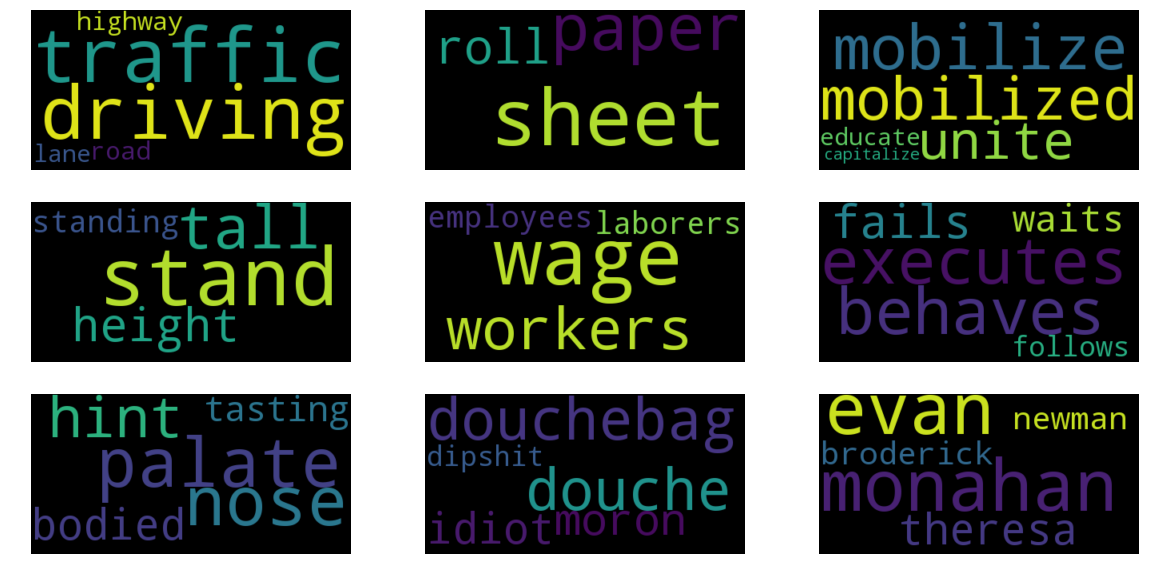

In [0]:
index = np.random.randint(1, word_number, 9)
plt.figure(figsize=(20,10))

for k in range(len(index)):
    plt.subplot(3, 3, k+1)
    
    x = index[k]
    text = ' '.join([index_word[x]] + [index_word[synonyms[x][i]] for i in range(synonyms_number-1)]) 
    wordcloud = WordCloud(stopwords=[]).generate((text))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


#### Looks pretty good ! 

## Step 4 - Data Augmentation / Oversampling 

#### We work on 1 labelled texts. We apply the following algorithm to modify a sentence :

For each word in the sentence :
* Keep it with probability $p$  (or if we don't have synonyms for it)
* Randomly swap it with one of its synonyms with probability $1-p$

In [0]:
X_pos = X[y=='GRP']

def modify_sentence(sentence, synonyms, p=0.9):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence
  
n_texts = 1400
indexes = np.random.randint(0, X_pos.shape[0], n_texts)

X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
y_gen = np.ones(n_texts)

def get_sentence(modified):
  return ' '.join([index_word[x] for x in modified])

X_new = np.concatenate((X_pos, X_gen), axis=0)
X_grp = pd.DataFrame({"tweet":np.apply_along_axis(get_sentence, 1, X_new)})
X_grp["subtask_c"] = "GRP"
X_grp.tweet = X_grp.tweet.str.strip()

In [0]:
X_pos = X[y=='OTH']

def modify_sentence(sentence, synonyms, p=0.9):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence
  
n_texts = 2700
indexes = np.random.randint(0, X_pos.shape[0], n_texts)

X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
y_gen = np.ones(n_texts)

def get_sentence(modified):
  return ' '.join([index_word[x] for x in modified])

X_new = np.concatenate((X_pos, X_gen), axis=0)
X_oth = pd.DataFrame({"tweet":np.apply_along_axis(get_sentence, 1, X_new)})
X_oth["subtask_c"] = "OTH"
X_oth.tweet = X_oth.tweet.str.strip()

In [0]:
X_ind = df[df['subtask_c']=='IND']
X_ind = X_ind.drop(['id'],axis=1)

In [0]:
new_data = pd.concat([X_ind,X_oth,X_grp],axis=0)
new_data.to_csv('all_train_data.tsv',sep='\t',index=False)

In [0]:
X_test = X_test.drop('id',axis=1)
X_test.to_csv('all_dev_data.tsv',sep='\t',index=False)

In [0]:
from google.colab import files
files.download('all_train_data.tsv')
files.download('all_dev_data.tsv')